# Demo of Perfect Model Predictability Functions

This demo demonstrates `climpred`'s capabilities for a perfect-model framework ensemble simulation.

**What's a perfect-model framework simulation?**

A perfect-model framework uses a set of ensemble simulations that are based on a General Circulation Model (GCM) or Earth System Model (ESM) alone. There is *no* use of any reanalysis, reconstruction, or data product to initialize the decadal prediction ensemble. An arbitrary number of `members` are initialized from perturbed initial conditions, and the control simulation can be viewed as just another member, in `climpred`'s view as member 0.


**How to compare predictability skill score:**
As no observational data interferes with the random climate evolution of the model, we cannot use an observation-based reference for computing skill scores. Therefore, we can compare the members with one another (`m2m`), against the ensemble mean (`m2e`), or against the control (`m2c`). We can also compare the ensemble mean to the control member (`e2c`). See the [comparisons](https://climpred.readthedocs.io/en/latest/comparisons.html) page for more information.

**When to use perfect-model frameworks:**

- You don't have a sufficiently long observational record to use as a reference.
- You want to avoid biases between model climatology and reanalysis climatology.
- You want to avoid sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation.
- You want to delve into process understanding of predictability in a model without outside artifacts.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import climpred

xr.set_options(display_style="text")

<IPython.core.display.Javascript object>

**Load sample data**

Here we use a subset of ensembles and members from the MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state.

## 1-dimensional output

Our 1D sample output contains datasets of time series of certain spatially averaged `area` (`'global'`, `'North_Atlantic'`) and temporally averaged `period` ('ym', 'DJF', ...) for some `lead` years (1, ..., 20).

`ds`: The ensemble dataset of all `member`s (1, ..., 10), `init`s (initialization years: 3014, 3023, ..., 3257), `area`s, `period`s, and `lead` years.

`control`: The control dataset with the same areas and periods, as well as the years 3000 to 3299.

In [3]:
ds = climpred.tutorial.load_dataset("MPI-PM-DP-1D").isel(area=1, period=-1, drop=True)
control = climpred.tutorial.load_dataset("MPI-control-1D").isel(
    area=1, period=-1, drop=True
)

ds["lead"].attrs = {"units": "years"}

<IPython.core.display.Javascript object>

We'll sub-select annual means (`'ym'`) of sea surface temperature (`'tos'`) in the North Atlantic.

In [4]:
# Add to climpred PerfectModelEnsemble object.
pm = climpred.PerfectModelEnsemble(ds)
pm = pm.add_control(control)
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (lead, init, member) float32 ...
    sos      (lead, init, member) float32 ...
    AMO      (lead, init, member) float32 ...
Control:
    tos      (time) float32 ...
    sos      (time) float32 ...
    AMO      (time) float32 ...
Uninitialized:
    None


/Users/aaron.spring/Coding/climpred/climpred/utils.py:122: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<IPython.core.display.Javascript object>

`PredictionEnsemble.plot()` displays ensemble timeseries for 1-dimensional data.

<AxesSubplot:title={'center':' '}, xlabel='time', ylabel='tos'>

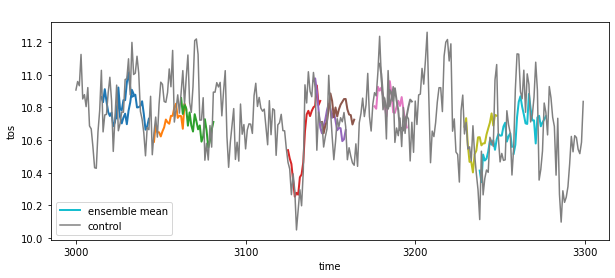

<IPython.core.display.Javascript object>

In [5]:
pm.plot()

### Verification

Optionally, `PredictionEnsemble.verify(reference=...)` verifies against reference forecasts (like persistence or historical).

In [6]:
pm = pm.generate_uninitialized()

<IPython.core.display.Javascript object>

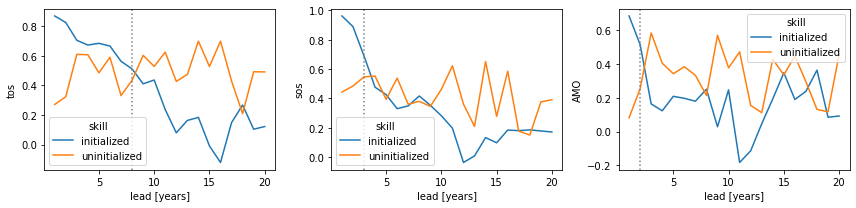

<IPython.core.display.Javascript object>

In [7]:
from climpred.horizon import horizon

skill = pm.verify(
    metric="acc", comparison="m2e", dim=["init", "member"], reference=["uninitialized"]
)
ph = horizon(skill.sel(skill="initialized") > skill.sel(skill="uninitialized"))
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
for i, v in enumerate(skill.data_vars):
    fg = skill[v].plot(hue="skill", ax=ax[i])
    # adds gray line at last lead where initialized > uninitialized
    ax[i].axvline(x=ph[v], c="gray", ls=":", label="predictability horizon")
plt.tight_layout()

### Bootstrapping with Replacement

Here, we bootstrap the ensemble with replacement [Goddard et al. 2013] to compare the initialized ensemble to an "uninitialized" counterpart and a persistence forecast. The visualization is based on those used in [Li et al. 2016]. The p-value demonstrates the probability that the uninitialized or persistence beats the initialized forecast based on N bootstrapping with replacement.

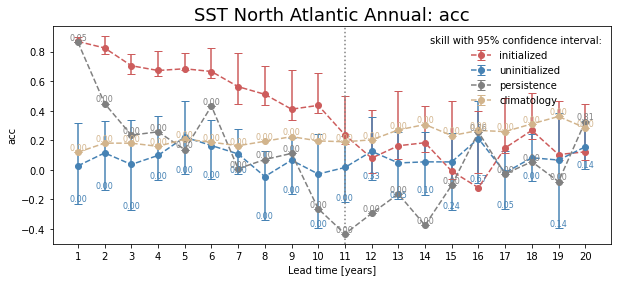

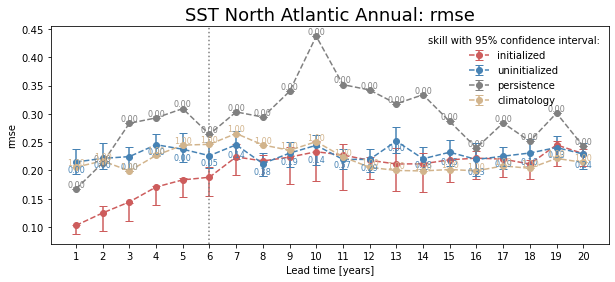

<IPython.core.display.Javascript object>

In [8]:
for metric in ["acc", "rmse"]:
    bootstrapped = pm[["tos"]].bootstrap(
        metric=metric,
        comparison="m2e",
        dim=["init", "member"],
        iterations=21,
        sig=95,
        reference=["uninitialized", "persistence", "climatology"],
    )

    climpred.graphics.plot_bootstrapped_skill_over_leadyear(bootstrapped)
    # adds gray line where last lead p <= 0.05
    ph = horizon(bootstrapped.sel(results="p", skill="uninitialized") <= 0.05)
    plt.axvline(x=ph.tos, c="gray", ls=":", label="predictability horizon")
    plt.title(" ".join(["SST", "North Atlantic", "Annual:", metric]), fontsize=18)
    plt.ylabel(metric)
    plt.show()

### Computing Skill with Different Comparison Methods

Here, we use `compute_perfect_model` to compute the Anomaly Correlation Coefficient (ACC) with different comparison methods. This generates different ACC values by design. See the [comparisons](https://climpred.readthedocs.io/en/latest/comparisons.html) page for a description of the various ways to compute skill scores for a perfect-model framework.

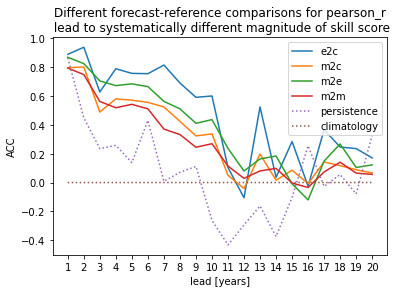

<IPython.core.display.Javascript object>

In [9]:
for c in ["e2c", "m2c", "m2e", "m2m"]:
    dim = "init" if c == "e2c" else ["init", "member"]
    pm.verify(metric="acc", comparison=c, dim=dim)["tos"].plot(label=c)
# Persistence computation for a baseline.
for r in ["persistence", "climatology"]:
    pm.verify(metric="acc", comparison=c, dim=dim, reference=r)["tos"].sel(
        skill=r
    ).plot(label=r, ls=":")
plt.ylabel("ACC")
plt.xticks(np.arange(1, 21))
plt.legend()
plt.title(
    "Different forecast-reference comparisons for pearson_r"
    "\n lead to systematically different magnitude of skill score"
)
plt.show()

## 3-dimensional output (maps)

We also have some sample output that contains gridded time series on the curvilinear MPI grid. Our compute functions (`compute_perfect_model`, `compute_persistence`) are indifferent to any dimensions that exist in addition to `init`, `member`, and `lead`. In other words, the functions are set up to make these computations on a grid, if one includes `lat`, `lon`, `lev`, `depth`, etc.

`ds3d`: The ensemble dataset of `member`s (1, 2, 3, 4), `init`s (initialization years: 3014, 3061, 3175, 3237), and `lead` years (1, 2, 3, 4, 5).

`control3d`: The control dataset spanning (3000, ..., 3049).

**Note**: These are very small subsets of the actual MPI simulations so that we could host the sample output maps on Github.

In [10]:
# Sea surface temperature
ds3d = climpred.tutorial.load_dataset("MPI-PM-DP-3D")[["tos"]]
control3d = climpred.tutorial.load_dataset("MPI-control-3D")[["tos"]]

ds3d["lead"].attrs = {"units": "years"}

<IPython.core.display.Javascript object>

In [11]:
# Create climpred PerfectModelEnsemble object.
pm = climpred.PerfectModelEnsemble(ds3d).add_control(control3d).generate_uninitialized()

/Users/aaron.spring/Coding/climpred/climpred/utils.py:122: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<IPython.core.display.Javascript object>

### Maps of Skill by Lead Year

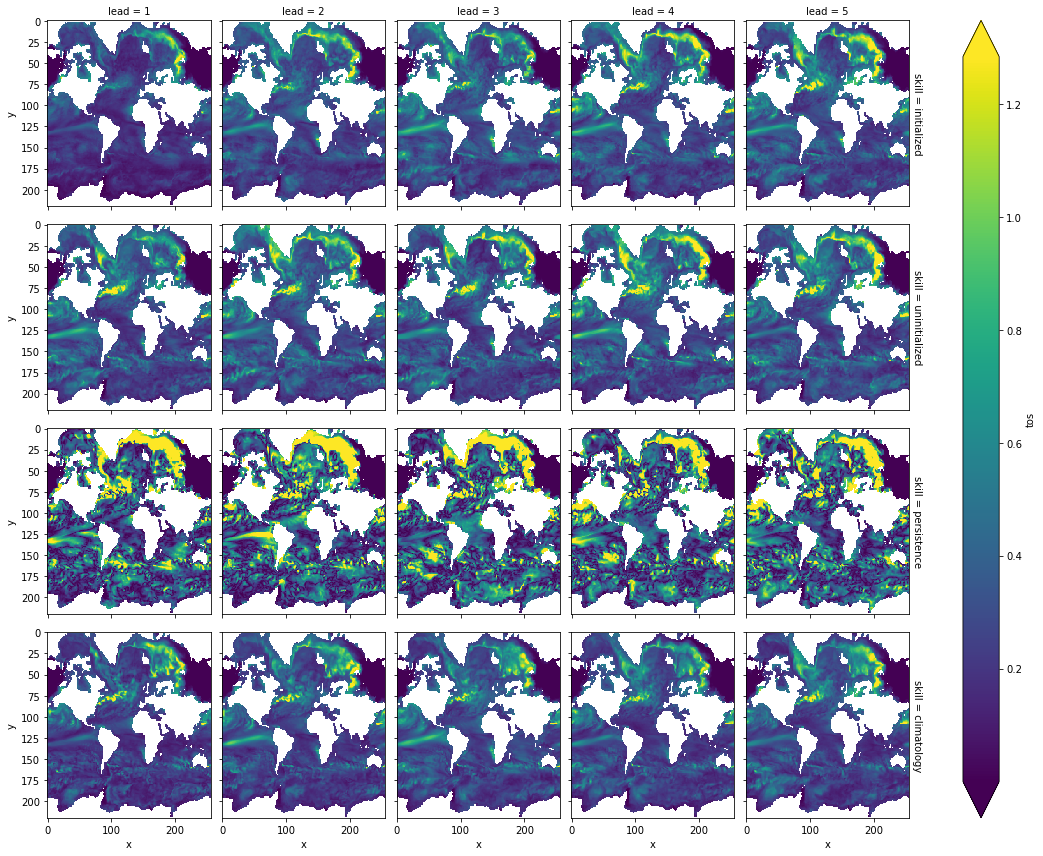

<IPython.core.display.Javascript object>

In [12]:
skill = pm.verify(
    metric="mae",
    comparison="m2e",
    dim=["init", "member"],
    reference=["uninitialized", "persistence", "climatology"],
)
skill.tos.T.plot(col="lead", row="skill", yincrease=False, robust=True)

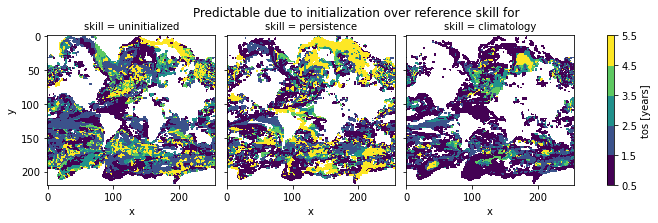

<IPython.core.display.Javascript object>

In [13]:
# initialized data has only five leads
ph = horizon(skill.sel(skill="initialized") < skill.drop_sel(skill="initialized"))

ph.tos.T.plot(yincrease=False, levels=np.arange(0.5, 5.51), col="skill")
plt.suptitle("Predictable due to initialization over reference skill for", y=1.02)
plt.show()

## References

1. Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
1. Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
1. Goddard, Lisa, et al. "A verification framework for interannual-to-decadal predictions experiments." Climate Dynamics 40.1-2 (2013): 245-272.
1. Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
1. Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
1. Li, Hongmei, Tatiana Ilyina, Wolfgang A. Müller, and Frank Sienz. “Decadal Predictions of the North Atlantic CO2 Uptake.” Nature Communications 7 (March 30, 2016): 11076. https://doi.org/10/f8wkrs.
1. Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.